---
title: "Paddy doctor"
author: "Bui Huu Dai"
date: "2024-12-30"
image: "./paddy-disease-farmer.jpg"
categories: ["kaggle", "competition", "deep learning"]
toc: true
---

Alright, we've been diving deep into tabular data lately, haven't we? We played with it, had some fun, and now i think it's time to go deeper to image classification problem. Yeah, we've touched on this before with the world simplest model ["Is it a Bird?"](https://bhdai.github.io/blog/posts/2024-06-30-your-deep-learning-journey/#exploring-the-is-it-a-bird-classifier), or better our simple model for [recognizing three types of bears](https://bhdai.github.io/blog/posts/2024-07-07-from-notebook-to-web-app/) but that was mostly about deployment. This time we're going all in.

> In an ideal world deep learning practitioners wouldn't have to know every detail of how things work under the hood… But as yet, we don't live in an ideal world. The truth is, to make your model really work, and work reliably, there are a lot of details you have to get right, and a lot of details that you have to check. This process requires being able to look inside your neural network as it trains, and as it makes predictions, find possible problems, and know how to fix them.

From now on, we'll be getting into the mechanics of deep learning, and exploring what a solid computer vision model architecture looks like.

Today we're dealing with the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/overview) competition on Kaggle. The goal? Predict paddy diseases based on images. Through this competitions we will go though, the general architecture, the presizing process, the loss, and improve our model further, alright let's get right into it shall we? 

In [2]:
#| echo: false
try: import fastkaggle
except ModuleNotFoundError:
  !pip install -Uq fastkaggle

from fastkaggle import *
import timm
from fastai.vision.all import *
set_seed(42)

In [3]:
if iskaggle:
  path = setup_comp('paddy-disease-classification', install="timm>=0.6.2.dev0")
else:
  path = Path("./data")

First we need to understand how our data laid out

In [6]:
path.ls()

(#4) [Path('data/test_images'),Path('data/train.csv'),Path('data/train_images'),Path('data/sample_submission.csv')]

Data is usually provided in one of these two ways:

- Individual files representing items of data, like images, text, can be organized in folders or with file name representing information about the images
- A table of data as we dealt with them before, where each row is an item which may include filenames providing a connection between the table and data in other format, such as text documents and images.

In [4]:
(path/"train_images/").ls()

(#10) [Path('data/train_images/bacterial_leaf_blight'),Path('data/train_images/bacterial_leaf_streak'),Path('data/train_images/bacterial_panicle_blight'),Path('data/train_images/blast'),Path('data/train_images/brown_spot'),Path('data/train_images/dead_heart'),Path('data/train_images/downy_mildew'),Path('data/train_images/hispa'),Path('data/train_images/normal'),Path('data/train_images/tungro')]

As you can see we have 10 folders each represent paddy diseases that we need to predict, in this case each folders will contain images of paddy disease correspond to the parent folder name

In [4]:
train_path = path/'train_images'
files = get_image_files(train_path)
files

(#10407) [Path('data/train_images/bacterial_leaf_blight/100023.jpg'),Path('data/train_images/bacterial_leaf_blight/100049.jpg'),Path('data/train_images/bacterial_leaf_blight/100126.jpg'),Path('data/train_images/bacterial_leaf_blight/100133.jpg'),Path('data/train_images/bacterial_leaf_blight/100148.jpg'),Path('data/train_images/bacterial_leaf_blight/100162.jpg'),Path('data/train_images/bacterial_leaf_blight/100169.jpg'),Path('data/train_images/bacterial_leaf_blight/100234.jpg'),Path('data/train_images/bacterial_leaf_blight/100248.jpg'),Path('data/train_images/bacterial_leaf_blight/100268.jpg'),Path('data/train_images/bacterial_leaf_blight/100289.jpg'),Path('data/train_images/bacterial_leaf_blight/100330.jpg'),Path('data/train_images/bacterial_leaf_blight/100365.jpg'),Path('data/train_images/bacterial_leaf_blight/100382.jpg'),Path('data/train_images/bacterial_leaf_blight/100445.jpg'),Path('data/train_images/bacterial_leaf_blight/100447.jpg'),Path('data/train_images/bacterial_leaf_blight/

Let's take a look a one

(480, 640)


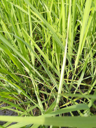

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

This image has the size of 480x640, let's check all their sizes. Looping though over 10.000 images is a pain right, so we will do it in parallel

In [14]:
#| echo: false
from fastcore.parallel import *

In [8]:
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

Well, there's almost have the same size except 4 of them with 640x480, we'll need to resize all of them to the same size, we will talk about it later, but now let's create a dataloader

In [15]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=parent_label,
                item_tfms=Resize(480, method='squish'),
                batch_tfms=aug_transforms(size=128, min_scale=0.75)).dataloaders(train_path)

This is the principle of our computer vision model mostly, but notice here, we need to focus on these two lines:

```python
item_tfms=Resize(480, method='squish'),
batch_tfms=aug_transforms(size=128, min_scale=0.75)).dataloaders(train_path)
```

These lines implement a fastai data augmentation strategy which they often call presizing. 


## Presizing

We need our images to have the same dimensions, so that they can collate into tensors to be passed into GPU. We also want to minimize the number of distinct augmentation computations we perform. If possible we should compose our augmentation transforms into fewer transform(to reduce number of computations and lossy operations) and transform images into uniform sizes(for more efficient processing in GPU)

However if we resize images to their final dimensions(the augmented size) and then apply various augmentation transforms it can lead to issues like creating empty zones (e.g., when rotating an image by 45 degrees) which will not teach the computer anything at all. Many rotation and zooming operations will require interpolating[^1] to create pixel

[^1]: Interpolation in image processing is the technique of estimating new pixel values when resizing or transforming a digital image. It's like filling in the blanks between known pixels to create a smooth transition when changing an image's size, rotation or shape

To walk around these challenges, presizing adopts a two-step strategy.

1. Images are resized to dimensions significantly larger than the target training size as this will create a "buffer zone" around the image allowing for more flexibility in subsequent augmentation.
2. All common augmentation operations, including the final resize to target dimensions, are combined into a single step performed on GPU at the end of the processing, rather than performing the operations individually and interpolating multiple times.


![Presizing explained: Showing the two step resize to a large size then apply random crop and augment at the same time](presizing.png){width=80%}


As you can see in the picture it demonstrate what i described earlier

1. First it crop full width or height this time it still do it sequentially before copied to GPU, it make sure that all our images are the same size. On the training set the crop area is chosen randomly[^2] and on validation set the it always choose the center square of the image. This is in `item_tfms`

[^2]: While the crop is indeed random, but it's not entirely arbitrary. The goal is to create diversity in the training data, which helps the model learn to recognize objects and features from various perspectives and scales. In practice, it often use multiple crops from a single image during training, this increase the chances of capturing important features at least some of the crops.

2. Then it uses `RandomResizedCrop` as a batch transform. It's applied to a batch all at once on the GPU, making it fast. For the training set, this includes random cropping and other augmentations, and for validation set only resizing to the final size needed for the model is done. This is in `batch_tfms`

### Resize

Use `Resize` as an item transform with a large size you can use `pad`[^pad] or `squish`[^squish] instead of `crop`[^crop](the default) for the initial `Resize` but what the diff between them? In fact let's see the different in action shall we? Here's the original image:

[^squish]: a resize method which resizes the image to fit the target dimensions, potentially distorting the aspect ratio. it helps preserves all information in the image, but at the same time it can distort the image, potentially altering important features. Use it when the aspect ratio is not crucial for your task, or when your imagees are already mostly square

[^pad]: a resize method which resizes the image to fit within the target dimensions and adds padding (usually black) to fill the rest, it keeps the original aspect ratio and all image information, however it can lead to artificial background which might affect model performance. Use it when you have to keep the entire image and the its aspect ratio is important and of course be a wear of extra background

[^crop]: Resizes the image and then crops it to fit the target dimensions. Help maintains aspect ratio of the visible part and doesn't introduce distortion, however it may lose important information at the edges of the image. Use it when the main subject is typically centered in your images, or when edge information is less important.

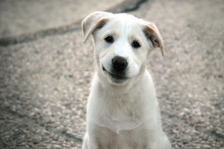

In [8]:
tst_img = PILImage.create('./test_image.jpg').resize((600,400))
tst_img.to_thumb(224)

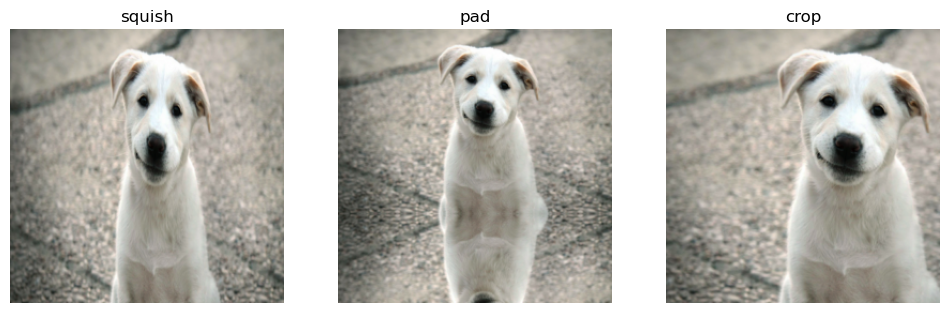

In [ ]:
_, axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), ['squish', 'pad', 'crop']):
  rsz = Resize(256, method=method)
  show_image(rsz(tst_img, split_idx=0), ctx=ax, title=method)

On the validation set, the crop is always a center crop (on the dimension that’s cropped).

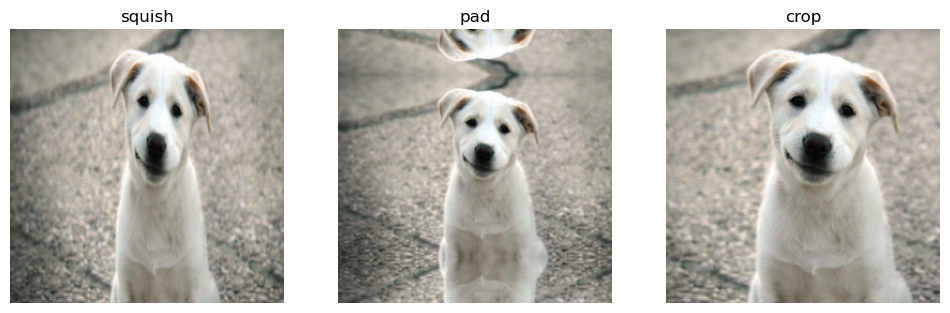

In [11]:
_, axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), ['squish', 'pad', 'crop']):
  rsz = Resize(256, method=method)
  show_image(rsz(tst_img, split_idx=1), ctx=ax, title=method)

My recommendation:

1. Start with padding if you're unsure. It preserve all information and aspect ratios.
2. If padding introduces too much background, try cropping.
3. Use squish only if you're sure it won't distort important features.
4. Always validate your choice by inspecting resized image and checking model performance

The best method can vary depending on the dataset the original aspect ratio. Now let's see what the `aug_transforms` does under the hood

### Augmentation

In [9]:
#| column: margin
torch.permute??

Docstring:
permute(input, dims) -> Tensor

Returns a view of the original tensor :attr:`input` with its dimensions permuted.

Args:
    input (Tensor): the input tensor.
    dims (tuple of int): The desired ordering of dimensions

Example:
    >>> x = torch.randn(2, 3, 5)
    >>> x.size()
    torch.Size([2, 3, 5])
    >>> torch.permute(x, (2, 0, 1)).size()
    torch.Size([5, 2, 3])
Type:      builtin_function_or_method

:::{.column-margin}
Most image processing libraries and formats (like PIL, OpenCV, matplotlib) use the format (Height, Width, Channels) or (H, W, C).

However, PyTorch expects images in the format (Channels, Height, Width) or (C, H, W).
:::

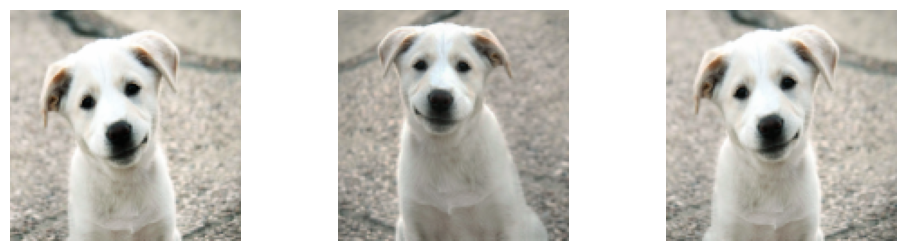

In [5]:
timg = TensorImage(array(tst_img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())
tfms = aug_transforms(size=128, min_scale=0.75)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_, axs = plt.subplots(1, 3, figsize=(12, 3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

Choosing the correct size for augment transforms is also crucial too as the size parameter in `aug_transforms` determines the final size of the images that will be fed into the model. Picking the right one depends on the model architecture requirements, each pretrained models requires different input size (e.g., `ResNet` typically use 224x224), but in fact you can do some experiments here. But aware of this, larger sizes help computer learn more details, but of course require more resources, in other hand smaller sizes are faster to process but may lose some details, it's a tradeoff


::: {.callout-note}
1. Start with the standard size for your chosen model architecture(e.g., 224 for many standard models)
2. If computational resources are not a big deal with you and the images have fine details, try increasing the size (e.g., 299, 384, 521)
3. If using transfer learning, stick to the pretrained model's original input size is the best option i'd say
4. For custom architectures, you got no choice but experiment with different sizes and choose based on performance and resource constraints.
:::




### Checking DataBlock

Writing `DataBlock` is just like writing a blueprint, we will get an error if we have a syntax error some where in the code. So it's a good practice to always check your data before doing anything further

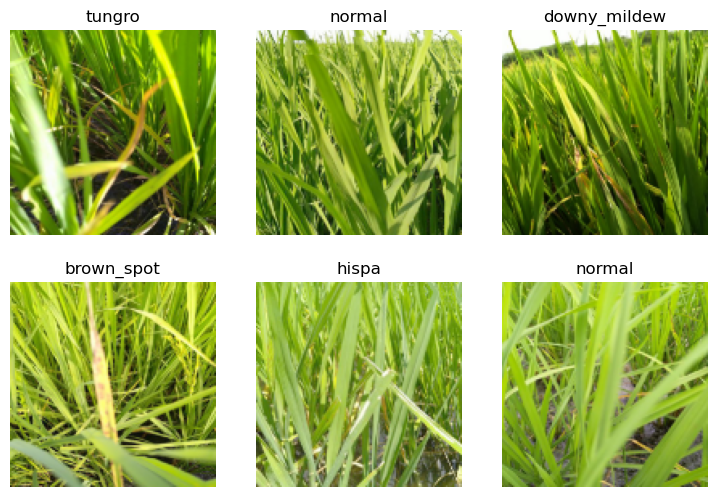

In [12]:
dls.show_batch(max_n=6)

Take a look at the images and and check that each one seems to have correct label or not. In fact, we often have to deal with data with which is not as familiar as domain experts may be. Indeed, if you're not a paddy doctor it will be hard to look at a random image and speak out the disease right? Since I'm not an expert on paddy diseases, I would use google to search to make sure the images look similar to what i see in the output. Also you can debug the DataBlock by using `DataBlock.summary`[^summary]

[^summary]: It will attempt to create a batch from the source you give it, with a lot of details. Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help. For instance, one common mistake is to forget to use a Resize transform, so you end up with pictures of different sizes and are not able to batch them.

Once you think your data looks right, it's a good practice to train a simple model, think about it, when you start trying to improve your model, how can you rate it? Compare it to the previous try you say, I mean what if it's already worse, so that why we need to know what our baseline result looks like. Maybe you don't need anything fancy - a basic model might do the job just fine. Or perhaps the data doesn't seems to train the model at all. These are things that you want to know as soon as possible

In [16]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')

In [17]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.966901,1.133069,0.356079,01:03


epoch,train_loss,valid_loss,error_rate,time
0,1.311612,0.885489,0.277751,01:03
1,1.032764,0.691636,0.218645,01:04
2,0.871234,0.645610,0.203748,01:03


Remember that we're in a competition right, so it's nothing better than submit it and see how it will go and again this time we will use an pretty cool tool call fastkaggle in fact we used it earlier. Alright let's see the submission layout

In [17]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


alright seems like we need to sort the images in order before submitting it

In [18]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

Let's make the prediction on the test set

In [19]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 7,  ..., 8, 1, 5])

Alright we got the indices of the diseases, we need to map the name to each diseases we can get the label by checking the `vocab`

In [20]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [21]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Before submit let's see if our file looks right

In [25]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [26]:
if not iskaggle:
  from kaggle import api
  api.competition_submit_cli('subm.csv', 'initial rn26d 128px', 'paddy-disease-classification')

100%|██████████| 70.1k/70.1k [00:01<00:00, 48.7kB/s]


Alright i got 0.8917 score on the competitions, it's not that good but it let's us know what the base line is, then we can improve it later on.

:::{.callout-note}
Remember that loss is whatever function we're decided to use to optimize the parameters of our models, here we're actually not specific what loss to use, fastai will try to find the best loss to use here for us. In this case we're using cross-entropy loss.
:::

## Cross-Entropy

*Cross-Entropy loss* is of course a loss function - a function that used to optimized the parameter of our model. It work even if our dependent variable has more than two categories, and results in faster and reliable training.

Let's look at the activation of our model, in fact let's just look at one batch of our data

In [6]:
x, y = dls.one_batch()

It returns the dependent and independent variables as mini-batch

In [19]:
y

TensorCategory([8, 9, 5, 8, 2, 1, 8, 7, 5, 8, 3, 6, 8, 3, 7, 4, 8, 3, 8, 6, 5,
                6, 0, 5, 8, 8, 7, 5, 8, 9, 8, 8, 7, 7, 9, 4, 7, 3, 9, 7, 7, 5,
                7, 9, 1, 7, 3, 4, 9, 6, 8, 7, 9, 5, 9, 7, 9, 5, 5, 9, 3, 3, 5,
                8], device='cuda:0')

We got 64 rows as our batch size is 64, and we get the values ranging from 0 to 9, representing our 10 possible diseases, alright we can even view the predictions in fact it is the activations of the final layer of our neural network by using `Learner.get_preds`

In [20]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([0.2162, 0.0061, 0.0008, 0.0299, 0.0109, 0.0082, 0.0068, 0.0107, 0.5600,
        0.1503])

The actual prediction are 10 probabilities between 0 and 1, which add up to 1.

In [21]:
len(preds[0]), preds[0].sum()

(10, tensor(1.))

### Softmax

When a model runs, it's last layer produces raw numbers, We call these `activations`, they are not probabilities yet, we need to change these raw number into probabilities, we want each number show how likely the model thinks each options is. So we use softmax activation in the final layer to ensure that the activations are all between 0 and 1. Softmax is similar to sigmoid function, below is what the sigmoid function look like in case you forget it

In [12]:
#| echo: false
def plot_function(f, title=None, min=-2.1, max=2.1, ylim=None, ty=None, tx=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), )
    if title is not None: plt.title(title)
    if tx: plt.xlabel(tx)
    if ty: plt.ylabel(ty)

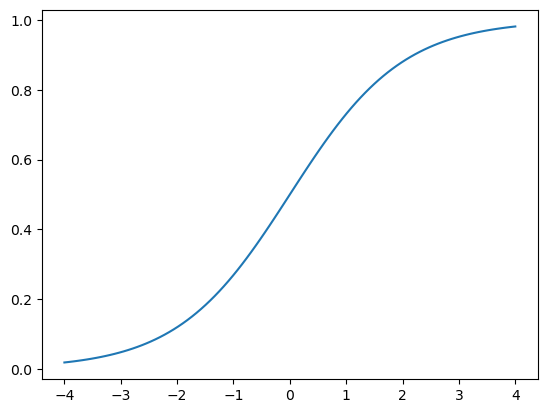

In [34]:
plot_function(torch.sigmoid, min=-4,max=4)

When you apply a sigmoid function to a single column of activation it turns those numbers to be between 0 and 1, it's pretty useful activations for our final layer. But hold on and think about it, what if we have more activations than just a single column, let's say we need to create a neural network that predict wether that image is a image of 3 or 7 that returns 2 activations (one for each number). Alright let's create 6 images and 2 categories(the first columns is 3, and other is 7)

In [6]:
torch.random.manual_seed(42);
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't pass this to a sigmoid function directly cuz we can not get rows that add up to 1

In [36]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

We need to use softmax. Here how we can represent the softmax function

```python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

:::{.column-margin}
Mathematically, here the softmax formula

$$
s(x_{i}) = \frac {e^{x_i}} {\sum _{j=1}^N e^{x_j}}
$$
:::

In [7]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In fact sofmax is the multi-category version of sigmoid, we need to use it anytime we have more that two categories and the probabilities must add up to 1

You might wondering why we have exponential the element here in the sofmax function, first of all, the obvious insight is that it helps to make the number to be positive, it also have a nice property: if one the numbers in our activations `x` is slightly bigger than the other the exponential will amplify it by make it closer to 1. That means the sofmax function really like to pick one class among others so that make sure that your each picture has definite labels

Softmax is just one part of the cross-entropy loss, we need to go through log likelihood

### Log likelihood

In binary case we use `torch.where` to select between `inputs` and `1-inputs`

```python
def mnis_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs)
```
Let's try to do this using pytorch, first we need to generate our label for 3s and 7s

In [5]:
targ = tensor([0,1,0,1,1,0])

Then each item of `targ` we can use that to select the appropriate column of `sm_acts` using tensor indexing, like this:

In [8]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

Pytorch provide a function which does just that (`sm_acts[range(6), targ]`) called `nll_loss` (NLL stands for negative log likelihood)

In [9]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [10]:
F.nll_loss(sm_acts, targ, reduction="none")

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

You might wondering why we need the negative anyway? Well because we want to minimize the loss, the log likelihood of correct label should be maximized(closer to 0 is better, as $\log(1)=0$). However optimization algorithms designed to minimize, not to maximize, by adding a negative sign we convert the maximization problem to minimization problem

The math behind it here is that let's say if *p* is the probability of the correct class then the negative log likelihood is $-\log(p)$ as *p* approaches 1(perfect prediction), the $-\log(p)$ approaches 0(minimum loss), as *p* approaches 0(bad predictions) $-\log(p)$ approaches infinity (maximum loss). Blow are plots demonstrate why we need a negative sign here

Text(0.5, 1.0, 'Negative Log Function')

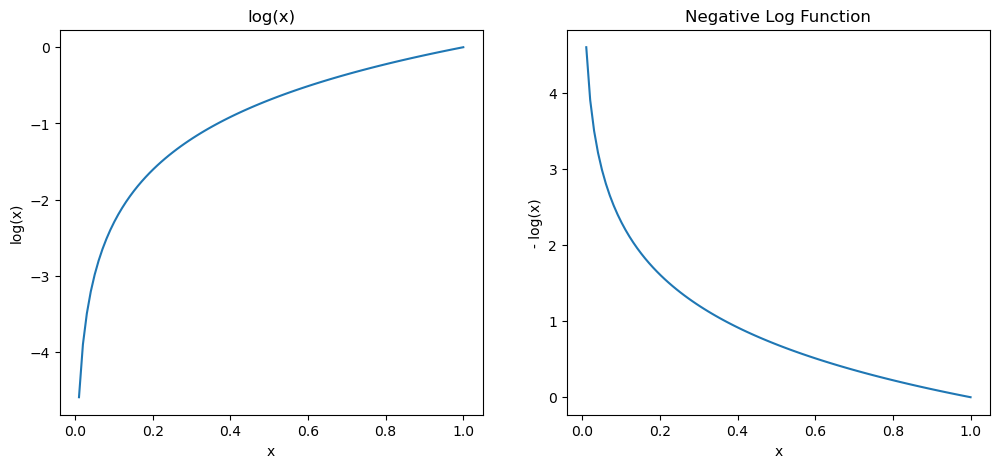

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
plt.sca(ax1)
plot_function(torch.log, min=0, max=1, ty="log(x)", tx='x')
ax1.set_title('log(x)')
plt.sca(ax2)
plot_function(lambda x: -1*torch.log(x), min=0, max=1, ty="- log(x)", tx='x')
ax2.set_title('Negative Log Function')

### I love Logs

Why is that? what if we have a very very small probabilities or even when working with multi-label classification[^multi-label] it may involve the multiplication of many small numbers, as you may know it will lead to problems like numerical underflow[^numerical-underflow] in computers. we want to transform these probabilities to a large values so we can perform mathematical operation on them. And there is a mathematical function that will help us doing that: *the logarithm* as you can see in the image above

[^multi-label]: in multi label classification, each instance can belong to multiple classes simultaneously, imagine working on a dog cat classification, where an image could contain both dog and cat at the same time so in this problem it requires us to do multiplications on probabilities which will lead to numerical underflow problem in computer science

[^numerical-underflow]: Number underflow occurs when a computation results in a number too small for computer to represent accurately, often leading to be rounded to 0

Not stop there tho, we do want to ensure that our model is able to detect the differences between small numbers as our loss need to be sensitive enough to small changes in probabilities(especially when the model's predictions are very wrong). Say, probabilities of 0.01 and 0.001 those number are very close together, but in probability, 0.001 is 10 times more confident compare to 0.01. Having said that, by taking the log out of our probabilities, we prevent these important different from being ignored.

One more thing that make log being amazing is this relationship:

$$
\log(a\times b) = \log(a) + \log(b)
$$

What this relationship tells us? Well this means the logarithm increases linearly when the argument increases exponentially or multiplicatively. Logarithms are awesome because when we do multiplication which can create really really large or really really small numbers, can be replaced by addition, which produce numbers that our computer can handle

We compute the loss on the column that contains the correct label, because there's only one right answer per example, we don't need to consider the others, because by the definition of softmax, the remain columns is indeed equal 1 minus the activation correspond to the correct label, then we'll have a loss function that tells how well we are predicting each image. Therefore, making the activation of the correct label as high as possible will also decreasing the activations of the remaining columns

### Negative Log Likelihood

Then what we do next? We will take the mean of negative log of our probabilities in other the word for each sample(image) we take the negative log of the predicted probability for the correct class as above this give us the loss for each individual sample we then calculate the mean of these individual losses across all samples, that give us the negative log likelihood or cross-entropy loss. One thing to note here that the Pytorch `nll_loss` assume that you already take the log of the softmax, even on it name have the word log but it dose not do it for you unfortunately

So that is cross-entropy loss in Pytorch, this is available as `F.cross_entropy` ofr `nn.CrossEntropyLoss` the `F` namespace version seems to be used more often by people

In [44]:
loss_func = nn.CrossEntropyLoss()

In [45]:
loss_func(acts, targ)

tensor(1.8045)

In [46]:
F.cross_entropy(acts, targ)

tensor(1.8045)

By default PyTorch loss functions take the mean of the loss of all items. You can use reduction='none' to disable that:

In [47]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

Let's look at the loss above those are numbers that the computer can learn from, but with us human, it is hard to look at those number and and tell how good our model is, so that why we need metrics, Those number are not used in the optimization process but just to help us poor human understand what's going on. We can also use the confusion matrix to see where our model perform good and not

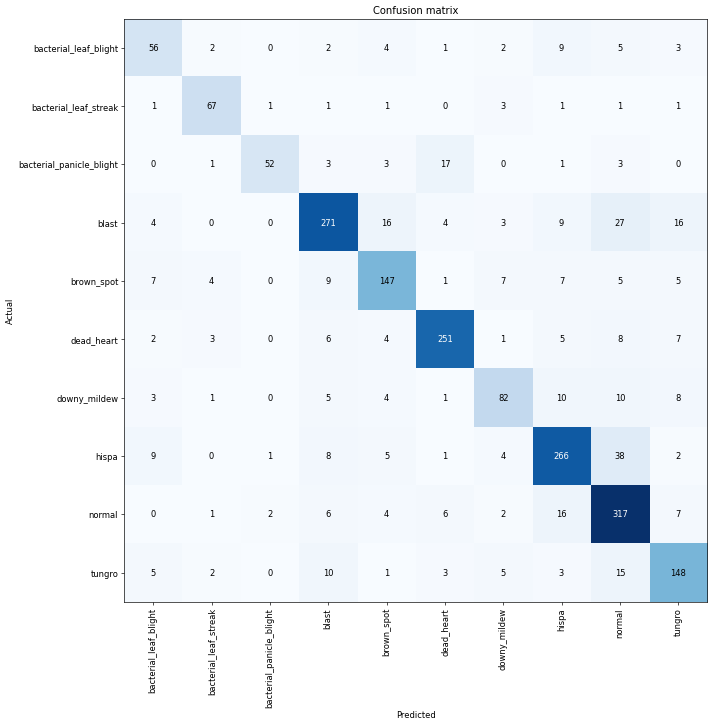

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Looking for a learning rate

One of the most important things we can do is to find the just right learning rate, if our learning rate is too high our optimizer will step too far from the minimal loss, and repeating this multiple time just make it jump around each side of the valley. Alright just make the learning rate really small to make sure it will never pass our minimal loss right? well of course it can take many epochs to train our model to go to the point, and it not only a waste of time but potentially causing overfitting because each epoch we go though our entire data one time, if we repeat it too much time we would give the computer a chance to memorize it.

So how can we find the perfect learning rate? not too low, not too high but just right? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the *learning rate finder*. His idea was to start with a very, very small learning rate we use that for one mini-batch(not an epoch) and then look at the losses then increase the learning rate, say, x2, and we do it again and again until the loss get worse instead of better, then we know that we've gone too far it's time to slower down by selecting a learning rate a bit smaller that the previous one.

Here's the advice from fastai:

- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing


/home/monarch/miniconda3/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



SuggestedLRs(minimum=0.010000000149011612, steep=0.0006918309954926372)

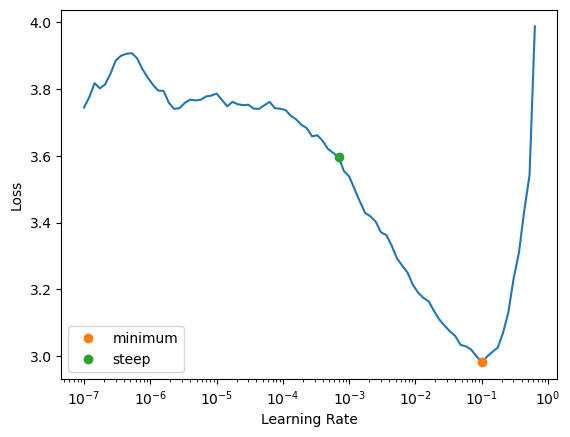

In [51]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')
learn.lr_find(suggest_funcs=(minimum, steep))

We can see in this plot that the range from 1e-6 to 1e-4 the model doesn't seem to train at all, from 1e-3 the loss start to decrease until it reaches the minimum at 1e-1 then increasing rapidly, obviously we don't want the learning rate after 1e-1 as i explained above. So choose 1e-1 then? While the loss minimum around the learning rate of 1e-1 it might give a good results, it's right at the edge of stable as after this point there's a sharp increase in the loos, in practice it often safer to choose a learning rate slightly lower than this threshold to ensure stability across different runs or datasets. Alright let's choose 3e-3 to see

In [53]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.861936,1.138522,0.362326,00:58


epoch,train_loss,valid_loss,error_rate,time
0,1.208978,0.829224,0.271985,01:04
1,0.943550,0.610545,0.196060,01:03
2,0.784365,0.570067,0.183085,01:03


Alright, we've got a pretty good learning rate, let's look at how we can fine-tune the weights of a pretrained model.

## Transfer Learning

We've used transfer learning a lot in fact but, what it really is, and how it work? Pretrained model is trained on millions of data points(such as ImageNet) then it is fine-tuned for other tasks.

We now know that a convolutional neural network consists of many layers with a nonlinear activation between each pairs of layers, followed by one or several final linear layers with an activation function like sofmax at the very end. The final linear layer uses a matrix that has number of columns(which determine the size of the outputs) should match the number of classes in our classification problem. This final layers is useless for us when we fine-tuning it because the number of class is likely different, the specific categories it was trained on to identify are different. So we throw it away and replace it with new linear layer with the correct number of outputs for our specific task.

When we add a new linear layer for our specific task it weights are indeed initialized randomly, despite that the entire pretrained model is not random at all, all the layers before the final layers still retain their pretrained weights, which encoded valuable information, such as finding gradient and edges, and later on layer can identify eyeballs, and fur. We want to train it in a way that make it still remember all of these generally useful ideas that it has trained on, and use that to solve our problem.

So our problem is replace the random weights in our added layers with weights that are correctly achieve our desire task without breaking the carefully pretrained weights. So what we can do is to tell the optimizer to only update the weights in those randomly added final layers, don't change the weights in the rest of the neuron network at all in other word freezing those pretrained layers. When we use `fine-tune` fastai automatically freezes all the pretrained layers for us, in fact it does these two things:

- First it trains the randomly added layers for one epoch, with all other layers frozen
- Then it unfreezes all other layers and train them all with the number of epoch we tell it

That why when fine-tune we always have a table with one column above then the table with the number of epoch blow it.

In fact `fine_tune` first does `fit_one_cycle` then unfreeze and does `fit_one_cycle` again. Alright let's do it manually this time

In [54]:
#| column: margin
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/lib/python3.12/site-packages/fastai/callback/schedule.py
Type:      method

In [6]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.797806,1.022250,0.333974,01:01
1,1.111010,0.680857,0.217203,01:02
2,0.841627,0.611456,0.190293,00:59


We unfreeze the model

In [7]:
learn.unfreeze()

We also need to fine a new learning rate because we trained it with more layers, and weights that already train for 3 epochs means our previous founded learning rate isn't appropriate anymore 

/home/monarch/miniconda3/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **tor

SuggestedLRs(valley=6.30957365501672e-05)

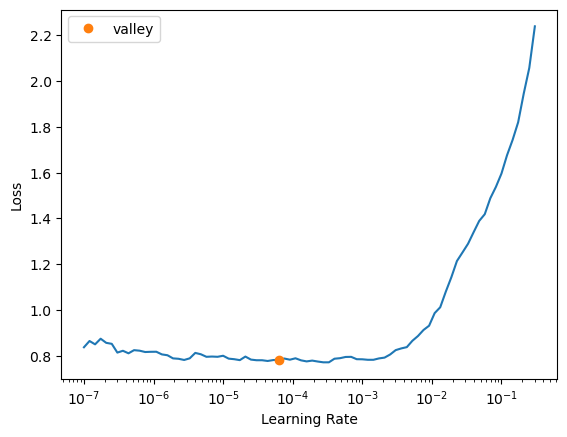

In [8]:
learn.lr_find()

alright let's pick 1e-4 this time

In [9]:
learn.fit_one_cycle(6, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.719057,0.490316,0.155694,01:06
1,0.512388,0.341793,0.097549,01:05
2,0.364478,0.241446,0.069678,01:04
3,0.255537,0.206497,0.064392,01:00
4,0.207048,0.193223,0.059106,01:05
5,0.171621,0.182925,0.057184,01:03


Well it improve our model a lot from 0.18 to 0.06, in fact when i submit the predictions from the model we've built i got a pretty good result, it's 0.93778, which improves a lot. Alright let's see how our model train

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

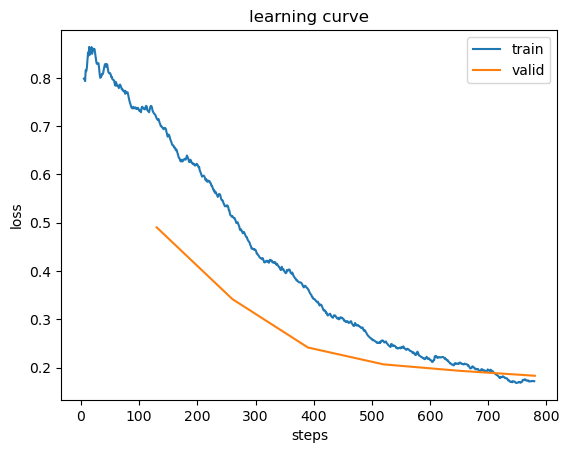

In [10]:
learn.recorder.plot_loss()

## How Long to Train?

Well the first approach to train should be simply pick a number of epochs that will train in the amount of time that you're happy to wait for, maybe take a cup of water, scrolling reddit, reading stuff,... then look at the training and validation loss plot like above and if you see it getting better when it comes to your final epochs, then you know that you should train it longer. In other hand you may see that the metrics you chosen really getting worse at the end of the training(remember that it's not just that we're looking for the validation loss to get worse, but the actual metrics). While the loss function is essential for optimization, what truly matters are your chosen practical metrics, don't be overly concerned with validation loss inconstancy if your metric are still improving.

If you find you've trained for too long (your metrics getting worse, loss getting worse), what you should do is retrain your model from scratch, really, and this time choose the number of epochs based on where your previous best result was found. One more thing if you have extra time available instead of just simply increasing epochs consider using that time to train more parameters or use deeper architecture, this can potentially yield better results than extended training of a simpler model.

## Mixed Precision Training

Alright let's train it for one more time. This time notice i use `to_fp16` here, it called *mixed-precision training* it used for speeding time up especially when we using a big architecture. I highly recommend you to read [this post from NVIDIA](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html).

But basically you first need to understand what is half-precision? Well it's a floating-point number format uses 16 bits to represent numbers it called half-precision as the more common are 32 bits (single precision) and 64 bits (double precision).

![half float](./fp16.png)

As you can see we have one bit to represent sign 5 for exponent bits while 10 for fraction bits. For instance, between 1 and 2, it can only represents the number $1, 1+2^{-10}, 1+2\ast2^{-10}$,... which mean if we plus 1 with a number smaller than $2^{-10}$(approximately 0.0009765625) we will get 1 instead of a number slightly greater than 1. let's say 1 + 0.0001 = 1 in half precision, that means it less precise than single or double precision, with only about 3 decimal digits of precision. So it helps reduce the memory usage by half compare to single precision, or we can double our batch, model size. Another very nice feature is that NVIDIA developed its latest GPUs (the Volta generation) to take fully advantage of half-precision tensors.

:::{.column-margin}
When we talk about $2^{-10}$, we're referring to the smallest positive value that can be represented in the fraction part of the number. We have 10 bits to represent fraction part which mean it can represent $2^{10} = 1024$ different values, these 1024 values are distributed eventually between 0 and 1. In fact, it's the smallest step between these values so we divide the range(which is 1 here) by the possible value ($2^{10}$):

$$
\frac{1}{2^{10}} = 2^{-10}
$$
:::


But there're several problem with half precision when using it:

1. The weight update is imprecise: What your optimizer does under the hood is basically this equation w = w - lr * w.grad for each weights of your network. So the problem is the w.grad is several order of magnitude below w especially as the network starts to converge, these gradient often become very small as the network is making tiny and tiny adjustment, even smaller than $2^{-10}$ is very common, so when using half precision, obviously the update doesn't do anything here as FP16 can't represent the tiny difference between w and (w - lr * w.grad).
2. During the backpropagation of gradients, the gradients themselves become so small that they are rounded down to 0 in FP16.
3. Your activation or loss can be overflow, the opposite problem from the gradients as during forward propagation, activation function like RElU or exponential function like softmax can produce a large values therefore it also make loss result in large numbers (especially in early training), it's more easier to hit nan(of infinity) in FP16 precision and your training my more likely diverge.

So the solution for this is mixed precision training, instead of fully train in FP16 precision some of the operations will be done in FP16, others in FP32. The main idea is that we will do the forward pass and the gradient computation in half precision to go fast, but the update in single precision. So our training loop will look like this:

1. compute the output with FP16 model, and loss
2. back-propagate the gradients in half-precision
3. we copy the gradient in FP32 precision
4. do the update on the master model (in FP32 precision)
5. copy the master model in the FP16 model

:::{.callout-note}
Note that we will lose precision during step 5, and that the 1.0001 in one of the weights will go back to 1. But if the next update corresponds to add 0.0001 again, since the optimizer step is done on the master model, the 1.0001 will become 1.0002 and if we eventually go like this up to 1.0005, the FP16 model will be able to tell the difference.
:::


Alright that's solve the first problem. For the second problem we use something call the gradient scaling. To avoid the gradient getting zeroed by FP16 precision we multiple the loss by the scale factor(often scale=512), by multiplying the loss with a large numbers all the gradients are effectively made larger. Of course we don't want those 512-scaled gradients to be in the weight updates so that after converting them into FP32 we can divide them by this scale. So it change the loop to:

:::{.column-margin}
In fact the scaling factor that we multiply it with the loss can leads our gradients or our loss to be overflow. So there a way around this, which is just simple as this, first we will try with a very high scale factor and see if it cause overflow to our loss or gradients, if it does, we will try with the half of that big value and again until we get the largest loss scale possible that doesn't make our gradient overflow.
:::


1. compute the output with the FP16 model, then the loss
2. multiply the loss by scale and then back-propagate the gradients in half precision
3. copy the gradients in FP32 precision then divide them by the scale
4. do the update on the master model
5. copy the master model in FP16 model

For the last problem, the tricks offered by NVIDIA are to leave the batchnorm layers in single precision (they don’t have many weights so it’s not a big memory challenge) and compute the loss in single precision (which means converting the last output of the model in single precision before passing it to the loss).

Alright let's apply our mixed precision strategy to our model, when we create a learner we call `to_fp16()`.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0012022644514217973, slide=0.002511886414140463)

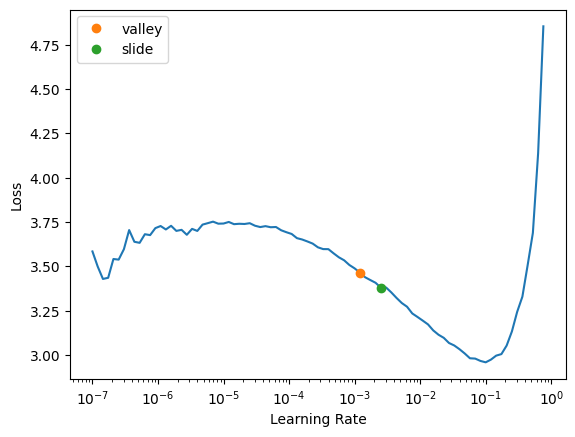

In [12]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()
learn.lr_find(suggest_funcs=[valley, slide])

In [13]:
learn.fine_tune(14, 1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.907815,1.100638,0.353676,00:41
1,1.442608,1.050639,0.346468,00:41
2,1.303783,0.873419,0.289284,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.892789,0.587087,0.187410,00:42
1,0.721903,0.487567,0.159058,00:41
2,0.625562,0.414129,0.140317,00:42
3,0.559306,0.321464,0.098510,00:41
4,0.437455,0.248258,0.069678,00:41
5,0.332489,0.218854,0.059106,00:42
6,0.265161,0.221709,0.059106,00:41
7,0.205299,0.193941,0.052859,00:41
8,0.189015,0.177993,0.044690,00:42
9,0.141942,0.173127,0.044690,00:42


Alright let's see if it's better, the best way to check is to submit it to kaggle we just do the same thing as above, just copy and past it here.

In [14]:
ss = pd.read_csv(path/'sample_submission.csv')
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This time i got a little higher result, i got 0.95967 as score which is pretty understandable as we trained it with 14 epochs, but yeah that was pretty cool.

## Scaling up



Alright, can we do better, let's see how far we can go, let's do some experimenting, we will use different architectures and image processing approaches, for the sake of convenient let's put our steps together into a little function.

:::{.callout-note}
Note that we can use `ImageDataLoader.from_folder` for our dataloader for make it shorter, but in general it the same as DataBlock
:::

In [3]:
def train(arch, item, batch, epochs=5):
  dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
  learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
  learn.fine_tune(epochs, 1e-2)
  return learn

To have a better result, one way to archive this is to use a better model right, but what to choose, well Jeremy Howard has a really good [notebook](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) that helps us choosing a appropriate architecture for our model based on what kind of problem you're dealing, the GPU memory, error rate, time,... But basically there are two key to choose the right one:

1. How similar between our dataset and the pretrained model's dataset.
2. How large they are.

Then it turned out that when it comes to computer vision model `convnext` model is one of the best, if not the best till now so let's give it a try shall we?

In [4]:
arch = "convnext_small_in22k"

From now on, if you not sure what architecture to use, just use this, right. And of course we have different version of `convnext` we have tinny, small, large... it will take more time to train but of course lower error rate. alright let's see how it will go

In [8]:
learn = train(arch, item=Resize(192,method="squish"), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.257208,0.790532,0.246997,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.610890,0.450510,0.146564,00:44
1,0.504428,0.302570,0.097069,00:44
2,0.299630,0.194396,0.061989,00:44
3,0.186308,0.130406,0.036521,00:44
4,0.134839,0.115092,0.035079,00:43


Well it did a pretty good job isn't it? we just do 5 epochs and we archive almost the same as the one we trained with 12 epochs, even our time to go through each epoch is the same(that's because i reduce the presize to 192X192 for it to run faster but it still produce the same performance as the previous one but with fewer epochs).


So one thing we could try is instead of using squish as our pre-processing let's try using padding, now we will use bigger presize so that when we use padding here we will get entire image but the downside is we also get few extra zero pixels which literally pointless, but whatever let's see if it work better

:::{.column-margin}
padding is interesting because it's the only way of pre-processing images which doesn't distort them and doesn't loose anything, if you crop you lose things, if you squish you distort things
:::

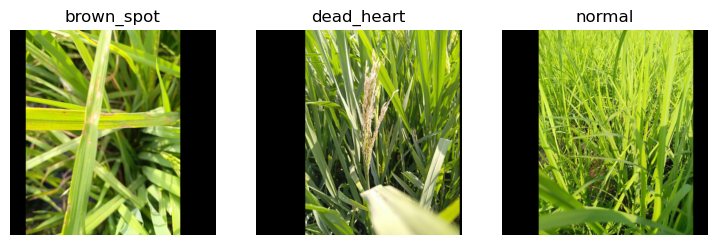

In [9]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [7]:
learn = train(arch, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256,192), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.091136,0.672584,0.214320,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.579350,0.418952,0.131187,01:36
1,0.430034,0.259760,0.086497,01:37
2,0.275291,0.176225,0.046612,01:38
3,0.147642,0.123821,0.037963,01:38
4,0.109251,0.107270,0.030274,01:38


As you can see it indeed did better, and its error_rate is the best we can get so far but not huge different yet!

### Test Time Augmentation

Well first let's look how can we calculate the error rate manually with our normal prediction

In [8]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.0303)

Well that actually the previous error-rate we got above, so what i'm doing here? well let's take a look at the images blow

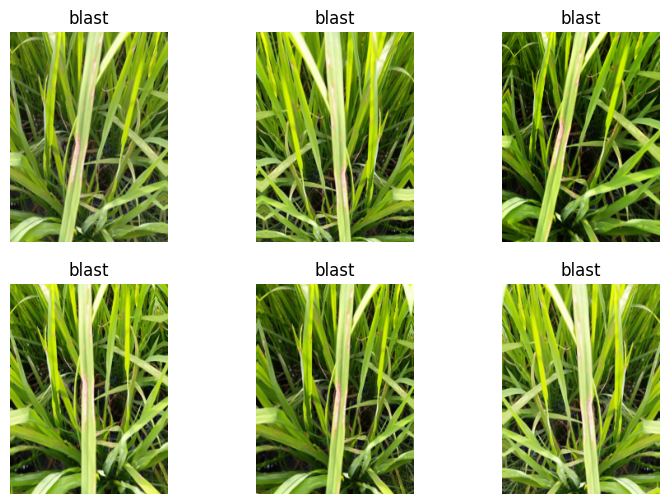

In [9]:
learn.dls.train.show_batch(max_n=6, unique=True)

Notice that, those are indeed the same picture but it gone through the data augmentation so sometimes it a bit darker, a bit lighter, sometimes it flipped horizontally, some times int zoom into a slightly different section, sometimes it rotate a little bit but those are all the same picture. So the idea of TTA(Test Time Augmentation) is maybe our model would like some of these version better than the others even the original image, so what we can do is we can pass all of these to our model get the prediction of all of them and take the average right, so if you read my previous blog, it's indeed the mini version of bagging approach. In fastai you can archive this by using the `tta` in our `learn` object

In [10]:
tta_preds,_ = learn.tta(dl=valid)

In [11]:
error_rate(tta_preds, targs)

TensorBase(0.0259)

See, we got better result like 10% better our previous. Alright let's train it with more epochs but this time let's just make a bigger image and something really interesting is that our images don't have to be square they just need to be in the same size right, it can be rectangular, having said that all of our original images are nearly 640x480, so we just need to pick one has the same aspect ratio for example 256x192 is good

In [5]:
learn = train(arch, epochs=12, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256,192), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.091136,0.672584,0.214320,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.534227,0.295779,0.100432,01:25
1,0.406855,0.259834,0.077847,01:26
2,0.345489,0.217263,0.065353,01:26
3,0.272754,0.186886,0.056704,01:26
4,0.220682,0.205609,0.054781,01:27
5,0.182489,0.122831,0.037001,01:27
6,0.118704,0.119720,0.035560,01:26
7,0.099475,0.117059,0.034118,01:26
8,0.071605,0.094223,0.025949,01:26
9,0.055326,0.096391,0.025949,01:26


Alright our error_rate down to 2.3% which is pretty good, now, let's what our error_rate when using tta

In [6]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0235)

Oops! it's worse this time, that's strange, i think it won't always produce a better error_rate, but maybe it will work well in practice i guess, alright forget about it, let's submit it

In [7]:
ss = pd.read_csv(path/'sample_submission.csv')
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)
preds,_ = learn.tta(dl=tst_dl)
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This time i got a little bit higher result, around 0.98 which is quite impressive. So we've gone through all of the essential concepts that we need to get familiar with as later we will delve deeper and deeper into more amazing thing later on, understand these concepts is like a solid groundwork for us to exploring even more fascinating topics in the future.